# P1 Procedure: Beam management in 5G networks using SSB

The P1 procedure, also known as the beam management procedure, is a mechanism used in 5G networks to facilitate efficient beam selection and management for communication between the base station (gNB) and user equipment (UE). Specifically, the P1 procedure focuses on the selection and tracking of the strongest beam from a set of possible beams transmitted by the gNB, known as the Secondary Synchronization Signal (SSB) beams.


## Import librariers

### Import Python libraries

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

### Import 5G Toolkit libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.ChannelModels     import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator

from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator

from toolkit5G.ChannelProcessing  import ApplyChannel, AddNoise
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPBCH

from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Simulation Parameters

In [3]:
terrain          = "UMa"    # Terrain      # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3.6*10**9        # Carrier frequency 3.6 GHz
scs              = 30*10**3   # Subcarrier Spacing
nBatches         = 10       # Number of Batches considered for simulation
numRBs           = 40         # Please don't change this. The simulation will break down
Bandwidth        = 10*10**6   # System bandwidth
Nfft             = 512        # FFT-size
bandwidthTx      = 10*(10**6);           # Transmission bandwidth
nSymbolFrame     = 140*int(scs/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

nBSs             = 21          # number of BSs 
nUEs             = nBatches   # number of UEs

txAntStruture    = np.array([1,1,4,4,2]) # Tx Antenna Structure
rxAntStruture    = np.array([1,1,2,2,1]) # Rx Antenna Structure
Nt               = txAntStruture.prod()
Nr               = rxAntStruture.prod()

print()
print("                  Terrain: "+terrain)
print("        Carrier Frequency: "+str(carrierFrequency/10**9)+" GHz")
print("       Subcarrier-Spacing: "+str(scs)+" kHz")
print("                Bandwidth: "+str(Bandwidth/10**6)+" MHz")
print("                 FFT-size: "+str(Nfft))
print("Number of Resource Blocks: "+str(nBatches))
print("Number of User Equipments: "+str(nUEs))
print("  Number of Base Stations: "+str(nBSs))
print("  Number of Base Antennas: "+str(Nt))
print("    Number of UE Antennas: "+str(Nr))

print()



                  Terrain: UMa
        Carrier Frequency: 3.6 GHz
       Subcarrier-Spacing: 30000 kHz
                Bandwidth: 10.0 MHz
                 FFT-size: 512
Number of Resource Blocks: 10
Number of User Equipments: 10
  Number of Base Stations: 21
  Number of Base Antennas: 32
    Number of UE Antennas: 4



## Generate Wireless Channel

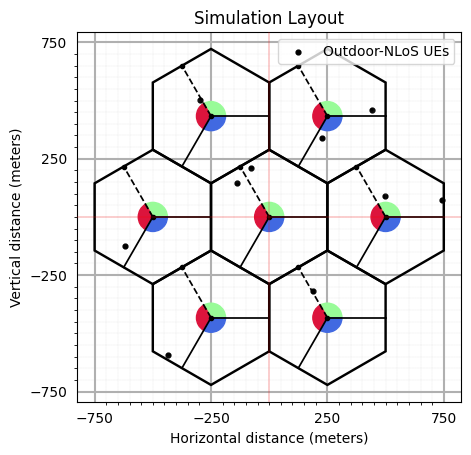

             Number of BSs: 21
          Shape of Channel: (1, 1, 21, 10, 512, 4, 32)
*****************************************************



In [4]:

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = rxAntStruture)
ueAntArray()

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = txAntStruture)
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

# # Node Mobility
# timeInterval = 15/scs           # number of SnapShots
# timeInst   = np.linspace(0, timeInterval, 14)
# UEroute    = NodeMobility("randomWalk", numUEs, timeInst, 1, 1, -0.7853981633974483, 0.7853981633974483, False)
# UEroute()

# fig, ax    = UEroute.displayRoute()
# ax.set_aspect(True)

# Layout Parameters
isd                  = 500        # inter site distance
minDist              = 35          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 25          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 3           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0#0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
forceLOS             = True       # boolen flag if true forces every link to be in LOS state
# forceLOS             = False      # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None, 
                                force3GPPSpatialConsistencyParameters = True, 
                                enableSpatialConsistencyLoS = True)

simLayoutObj(terrain = terrain, 
             carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

simLayoutObj.linkState = simLayoutObj.linkState*False

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()

# paramGen = simLayoutObj.getParameterGenerator(delaySpread=100*(10**(-9)),
#                                               enableAbsoluteDelays=True,
#                                               enableSpatialConsistencyForLSPs = True, 
#                                               enableSpatialConsistencyForSSPs = True,
#                                               enableSpatialConsistencyForInitialPhases = True)
paramGen = simLayoutObj.getParameterGenerator(delaySpread=100*(10**(-9)))
#paramGen.displayClusters((0,0,0), rayIndex = 5)

channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft)

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

print("             Number of BSs: "+str(nBSs))
print("          Shape of Channel: "+str(Hf.shape))
print("*****************************************************")
print()

## Generate Time Frequency Parameters and MIB+ATI Parameters

In [5]:
## This class fetches valid set of 5G parameters for the system configurations 
tfParams         = TimeFrequency5GParameters(Bandwidth, scs, fftsize=Nfft)
tfParams(nSymbolFrame, typeCP = "normal")
nRB              = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff             = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft             = 512                 # FFT-size for OFDM
lengthCP         = tfParams.lengthCP    # CP length


lamda                           = 3e8/carrierFrequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(carrierFrequency, nSCSOffset, ssbType="caseA",
                                                             nssbCandidatesInHrf = 8, isPairedBand = False, 
                                                             withSharedSpectrumChannelAccess = False)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________

## Generate OFDM Resource/Transmission Grid

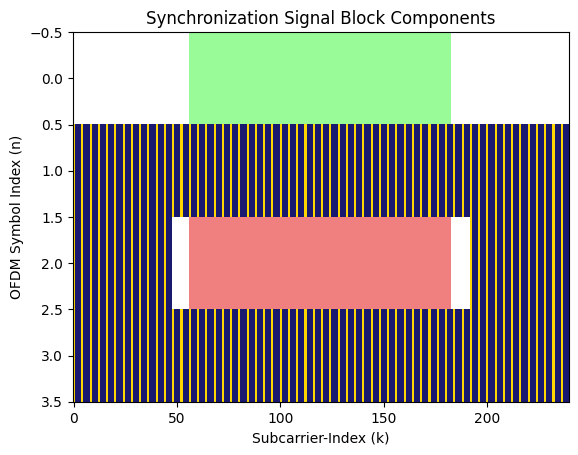

In [6]:
numSymbols = 56
Pt         = 53
nID2       = np.arange(3)
nID1       = np.arange(7)
bwpOffset  = np.random.randint(Nfft - numRBs*12)

azimuth      = np.linspace(0, 2*np.pi/3, nssbCandidatesInHrf, endpoint=False)
secAngle     = np.arange(nSectorsPerSite)*(2*np.pi/3)
theta        = 75*np.pi/180
antLocations = bsAntArray.locations[0,0].reshape(-1,3)
ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)

# Generate SSB
ssb         = np.zeros((21, 8, 4, 240), dtype=np.complex64)
Xf          = np.zeros((nBSs, Nt, numSymbols, Nfft),      dtype = np.complex64)


for nbs in range(nBSs):
    
    cellID1 = int(nbs/3)
    cellID2 = int(nbs%3)
    
    # Generate PSS sequence
    pssObject    = PSS(cellID2)
    pssSequence  = pssObject()

    # Generate SSS sequence
    sssObject    = SSS(cellID1, cellID2)
    sssSequence  = sssObject()

    ssbIndex     = np.arange(nssbCandidatesInHrf)

    # Generate DMRS sequence
    dmrsLen      = 144;
    dmrsObject   = DMRS("PBCH", nbs, ssbIndex, nssbCandidatesInHrf, hrfBit)
    dmrsSequence = dmrsObject(dmrsLen)
        
    pbchObject   = PBCH(carrierFrequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                        controlResourceSet0, searchSpace0, cellBarred, 
                        intraFrequencyReselection, systemFrameNumber, ssbSubCarrierOffset, 
                        hrfBit, ssbIndex, nbs, nssbCandidatesInHrf)

    pbchSymbols = pbchObject()

    ssbObject      = SSB_Grid(nbs)
    ssb[nbs]       = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)
    
    ssbRGobject    = ResourceMapperSSB(ssbType, carrierFrequency, isPairedBand, withSharedSpectrumChannelAccess)
    
    ssbGrid = ssbRGobject(ssb[nbs], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset[0],
                          offsetInRBs = 0, numRBs = numRBs)
    
    for nbm in range(nssbCandidatesInHrf):
        
        phi = azimuth[nbm] + secAngle[nbs%nSectorsPerSite]
        steeringVector = np.stack((np.sin(theta, dtype = np.float32)*np.cos(phi, dtype = np.float32),
                                   np.sin(theta, dtype = np.float32)*np.sin(phi, dtype = np.float32),
                                   np.cos(theta, dtype = np.float32)), axis = -1)[...,np.newaxis]

        beamVectors    = ((simLayoutObj.BSLocations[[nbs]] + antLocations)@steeringVector)/lamda
        beamVectors    = np.sqrt(Pt/Nt)*np.exp(-1j*2*np.pi*beamVectors)
        
        
        n = ssbRGobject.symbolIndices[nbm]
        Xf[nbs,:,n:n+4,bwpOffset:bwpOffset+numRBs*12] = beamVectors[...,np.newaxis]*ssbGrid[np.newaxis,n:n+4]
        
fig, ax = ssbObject.displayGrid()

## Pass through the Wireless Channel

In [7]:
# Pass through Channel
Y = (Hf[0,0,:,:,np.newaxis]@Xf.transpose(0,2,3,1)[:,np.newaxis,...,np.newaxis])[...,0]

## Power Heatmap of Received Grid

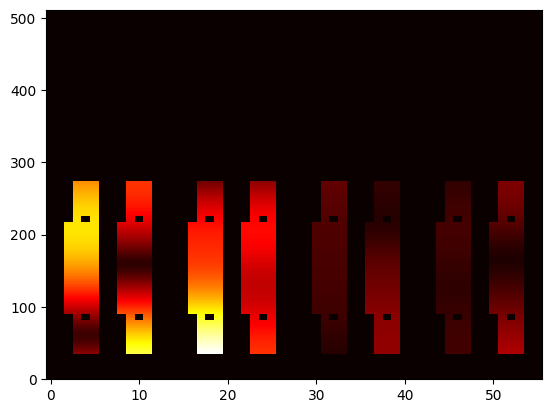

In [8]:
ui = np.random.randint(nUEs)
bi = np.random.randint(nBSs)
ai = np.random.randint(Nr)

fig, ax = plt.subplots()
ax.imshow(np.abs(Y[bi,ui,:,:,ai].T), cmap = "hot", interpolation= "nearest", aspect='auto', origin = "lower")
plt.show()

## Add Noise

In [9]:

BoltzmanConst = 1.380649*(10**(-23))
temperature   = 300
noisePower    = BoltzmanConst*temperature*numRBs*scs
kppm          = 0
fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
CFO           = (fCFO/scs)/Nfft

Yf            = np.complex64(AddNoise(False)(Y, noisePower, 0))    #Added


## RSRP Computation

In [10]:
# Rx Beamforming
numRxBeams = 8
combiner   = np.fft.fft(np.eye(numRxBeams))[:,0:Nr]

ssbEsti    = np.zeros((nBSs, nUEs, nssbCandidatesInHrf, 4, 240, numRxBeams), dtype = np.complex64)
ssbEst     = np.zeros((nUEs, 4, 240), dtype = np.complex64)
rsrp       = np.zeros((nBSs, nUEs, nssbCandidatesInHrf))

for nbm in range(nssbCandidatesInHrf):
    n = ssbRGobject.symbolIndices[nbm]
    ssbEsti[:,:,nbm] = (combiner.reshape(1,1,1,1,1,numRxBeams,Nr)@Yf[:,:,n:n+4,ssbSubCarrierOffset[0]:ssbSubCarrierOffset[0]+240,:, np.newaxis])[...,0]

    rsrp[:,:,nbm] = 10*np.log10((np.abs(ssbEsti[:,:,nbm,2,56:183])**2).mean(-2).max(-1)) + 30

bestBeams = rsrp.argmax(-1)

In [11]:
rsrp.shape

(21, 10, 8)

## Visualization of All Beam RSRP

In [12]:
ueIndex = 0

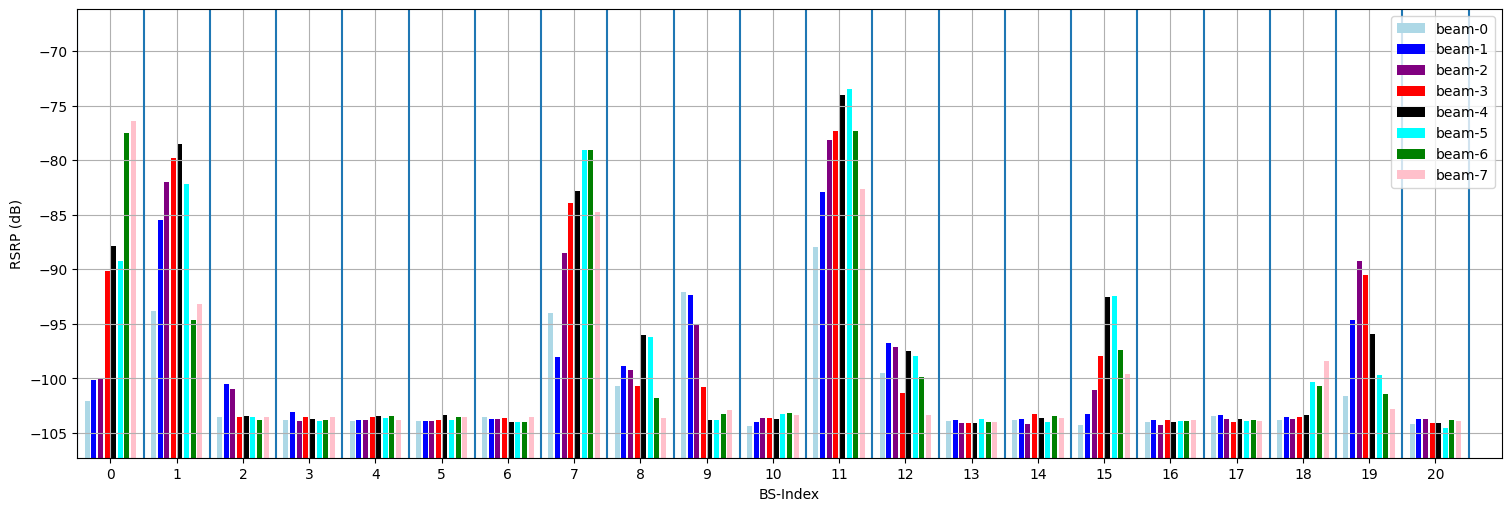

In [13]:
fig, ax = plt.subplots(layout='constrained', figsize = (15,5))

color      = ['lightblue', 'blue', 'purple', 'red', 'black', 'cyan', 'green', 'pink']
label      = ["beam-0", "beam-1", "beam-2", "beam-3", "beam-4", "beam-5", "beam-6", "beam-7"]

width      = 0.075
minVal     = -10*np.floor(rsrp[:,ueIndex].min()/10)

for nb in range(nBSs-1):
    rects = ax.bar(0.1*np.arange(nssbCandidatesInHrf) + nb - 0.35, rsrp[nb,ueIndex]+minVal, width, bottom = rsrp[:,ueIndex].min(), color = color)
 
nb = nBSs-1
rects = ax.bar(0.1*np.arange(nssbCandidatesInHrf) + nb - 0.35, rsrp[nb,ueIndex]+minVal, width, bottom = rsrp[:,ueIndex].min(), color = color, label = label)
ax.legend()

ax.set_xticks(np.arange(nBSs), minor=False)
ax.vlines(np.arange(nBSs+1) - 0.5, ymin = rsrp[:,ueIndex].min(), ymax = rsrp[:,ueIndex].max()+10)
ax.set_xlim([-0.5, 21])
ax.set_ylim([rsrp[:,ueIndex].min(), rsrp[:,ueIndex].max() + 10])
ax.set_xlabel("BS-Index")
ax.set_ylabel("RSRP (dB)")

ax.grid()

plt.show()

## Selected Base-station and Beam

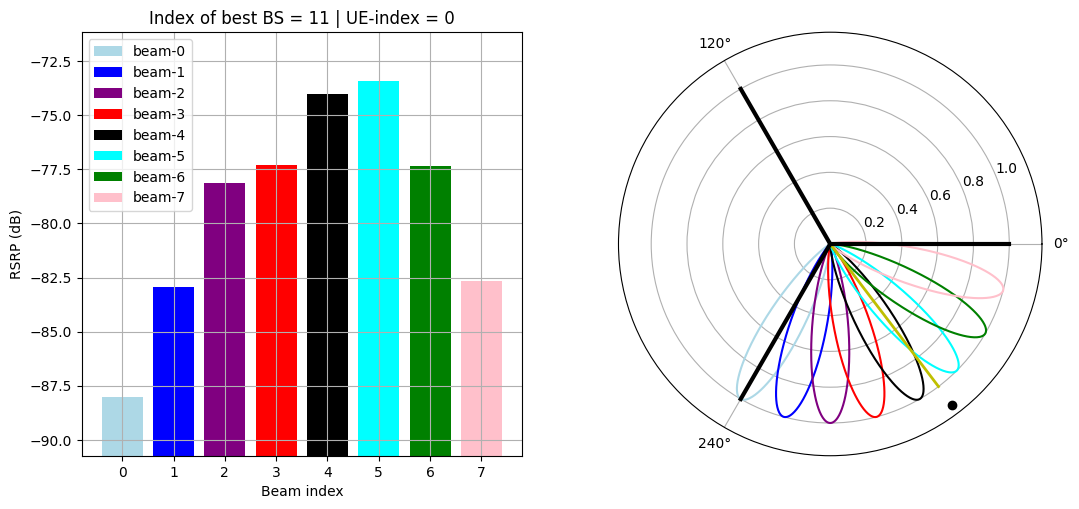

In [16]:
fig = plt.figure(figsize = (12.5, 5.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

width   = 0.8
idx   = np.argwhere(rsrp[:,ueIndex] == np.max(rsrp[:,ueIndex]))
nb    = idx[0][0]
rects = ax1.bar(np.arange(nssbCandidatesInHrf), rsrp[nb,ueIndex]+minVal, width, bottom = rsrp[:,ueIndex].min(), color = color, label = label)
ax1.legend()
ax1.set_xticks(np.arange(nssbCandidatesInHrf), minor=False)
ax1.set_ylim([rsrp[nb,ueIndex].min(), rsrp[nb,ueIndex].max() + 5])
ax1.set_xlabel("Beam index")
ax1.set_ylabel("RSRP (dB)")
ax1.set_title("Index of best BS = "+str(nb)+" | UE-index = "+str(ueIndex))
ax1.grid()


numPoints = 1000
numBeams  = 8
order     = 32

theta     = np.linspace(-0.5*np.pi, 0.5*np.pi, numPoints)
beamAngle = np.linspace(0, 2*np.pi/3, numBeams, endpoint=False) + (nb%3)*2*np.pi/3

for nbeam in range(numBeams):
    ax2.plot(beamAngle[nbeam] + theta, np.cos(theta)**order, zorder = 3, color = color[nbeam])
  
refLocation = simLayoutObj.UELocations[ueIndex] - simLayoutObj.BSLocations[nb]
radius = 2*np.linalg.norm(refLocation)/isd
phi    = np.arctan2(refLocation[1], refLocation[0])
ax2.plot(phi, radius, "k", marker='o', lw = 100, zorder = 4)
ax2.set_rmax(1)
ax2.plot([phi,phi], [0,1], "y", lw = 2, zorder = 4)
ax2.plot([2*np.pi/3,2*np.pi/3], [0,1], "k", lw = 3, zorder = 4)
ax2.plot([4*np.pi/3,4*np.pi/3], [0,1], "k", lw = 3, zorder = 4)
ax2.plot([0,0], [0,1], "k", lw = 3, zorder = 4)

# ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax2.set_thetagrids(np.arange(0,3)*120)

plt.show()

## Simulation Topology

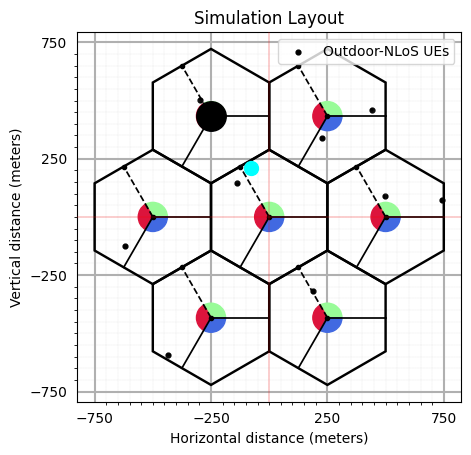

In [15]:
fig, ax = simLayoutObj.display2DTopology(displayPlot=False)
ax.scatter(simLayoutObj.UELocations[ueIndex,0], simLayoutObj.UELocations[ueIndex,1], color = "cyan", s = 100, zorder = 20)
ax.scatter(simLayoutObj.BSLocations[nb,0], simLayoutObj.BSLocations[nb,1], color = "k", s = 450, zorder = 21)
plt.show()
